In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "QLIKE" and crit != "MAD" and crit != "MAPE"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        #for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
        #    is_actual_ok = compiled_regex(str(abs(actual)))
        #    is_pred1_ok = compiled_regex(str(abs(pred1)))
        #    is_pred2_ok = compiled_regex(str(abs(pred2)))
        #    if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):
        #        msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
        #        rt = -1
        #        return (rt,msg)
        return (rt,msg)

    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np

    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []

    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()

    # Length of lists (as real numbers)
    T = float(len(actual_lst))

    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "QLIKE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((abs(actual)/abs(p1)-np.log(abs(actual)/abs(p1))-1))
            e2_lst.append((abs(actual)/abs(p2)-np.log(abs(actual)/abs(p2))-1))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)

    # Mean of d
    mean_d = pd.Series(d_lst).mean()

    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)

    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')

    rt = dm_return(DM = DM_stat, p_value = p_value)

    return DM_stat

In [3]:
HAR=pd.read_excel("HAR Forecasts.xlsx")#, index_col= "Date")

In [4]:
NBEATSx=pd.read_excel("NBEATSx forecasts.xlsx")#, index_col= "Date")

In [5]:
NHITS=pd.read_excel("NHITS forecasts.xlsx")#, index_col= "Date")

In [6]:
TimesNet=pd.read_excel("TimesNet forecasts.xlsx")#, index_col= "Date")

In [7]:
TFT=pd.read_excel("TFT forecasts.xlsx")#, index_col= "Date")
Autoformer=pd.read_excel("Autoformer forecasts.xlsx")
Informer=pd.read_excel("Informer forecasts.xlsx")
PatchTST=pd.read_excel("PatchTST forecasts.xlsx")

In [8]:
Actuals=pd.read_excel("Actuals.xlsx")

In [9]:
mask=HAR['Date'].isin(NBEATSx['Date'])
HAR=HAR.loc[mask]

In [10]:
mask=NBEATSx['Date'].isin(HAR['Date'])
NBEATSx=NBEATSx.loc[mask]

In [11]:
mask=NHITS['Date'].isin(HAR['Date'])
NHITS=NHITS.loc[mask]

In [12]:
mask=TimesNet['Date'].isin(HAR['Date'])
TimesNet=TimesNet.loc[mask]

In [13]:
mask=TFT['Date'].isin(HAR['Date'])
TFT=TFT.loc[mask]

In [14]:
mask=Autoformer['Date'].isin(HAR['Date'])
Autoformer=Autoformer.loc[mask]

In [15]:
mask=Informer['Date'].isin(HAR['Date'])
Informer=Informer.loc[mask]

In [16]:
mask=PatchTST['Date'].isin(HAR['Date'])
PatchTST=PatchTST.loc[mask]

In [17]:
mask=Actuals['Date'].isin(HAR['Date'])
Actuals=Actuals.loc[mask]

In [18]:
HAR.set_index('Date',inplace=True)
NBEATSx.set_index('Date',inplace=True)
NHITS.set_index('Date',inplace=True)
TimesNet.set_index('Date',inplace=True)
TFT.set_index('Date',inplace=True)
Autoformer.set_index('Date',inplace=True)
Informer.set_index('Date',inplace=True)
PatchTST.set_index('Date',inplace=True)
Actuals.set_index('Date',inplace=True)

# Error Metrics

RMSE

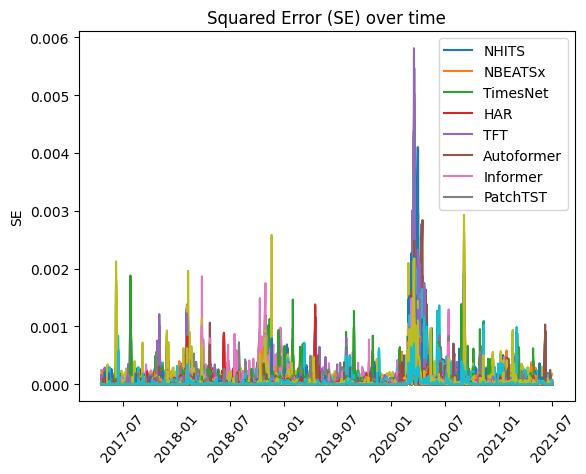

NHITS RMSE: 0.005633353631478223
NBEATSx RMSE: 0.005645474793831459
TimesNet RMSE: 0.00561240565604629
HAR RMSE: 0.006378997404613182
TFT RMSE: 0.005918088026463417
Autoformer RMSE: 0.005710108630380801
Informer RMSE: 0.005680168595056828
PatchTST RMSE: 0.005479940918861683


In [19]:
NHITS_RMSE=(NHITS-Actuals)**2
NBEATSx_RMSE=(NBEATSx-Actuals)**2
TFT_RMSE=(TFT-Actuals)**2
TimesNet_RMSE=(TimesNet-Actuals)**2
HAR_RMSE=(HAR-Actuals)**2
Autoformer_RMSE=(Autoformer-Actuals)**2
Informer_RMSE=(Informer-Actuals)**2
PatchTST_RMSE=(PatchTST-Actuals)**2

plt.plot(NHITS_RMSE)
plt.plot(NBEATSx_RMSE)
plt.plot(TimesNet_RMSE)
plt.plot(HAR_RMSE)
plt.plot(TFT_RMSE)
plt.plot(Autoformer_RMSE)
plt.plot(Informer_RMSE)
plt.plot(PatchTST_RMSE)
plt.ylabel("SE")
plt.title("Squared Error (SE) over time")
plt.legend(['NHITS','NBEATSx', 'TimesNet', 'HAR', 'TFT', 'Autoformer', 'Informer', 'PatchTST'])
plt.xticks(rotation=50)
plt.show()

NHITS_RMSE=np.sqrt(NHITS_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
NBEATSx_RMSE=np.sqrt(NBEATSx_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TFT_RMSE=np.sqrt(TFT_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TimesNet_RMSE=np.sqrt(TimesNet_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
HAR_RMSE=np.sqrt(HAR_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
Autoformer_RMSE=np.sqrt(Autoformer_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
Informer_RMSE=np.sqrt(Informer_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
PatchTST_RMSE=np.sqrt(PatchTST_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

print(f"NHITS RMSE: {NHITS_RMSE}")
print(f"NBEATSx RMSE: {NBEATSx_RMSE}")
print(f"TimesNet RMSE: {TimesNet_RMSE}")
print(f"HAR RMSE: {HAR_RMSE}")
print(f"TFT RMSE: {TFT_RMSE}")
print(f"Autoformer RMSE: {Autoformer_RMSE}")
print(f"Informer RMSE: {Informer_RMSE}")
print(f"PatchTST RMSE: {PatchTST_RMSE}")

MAE

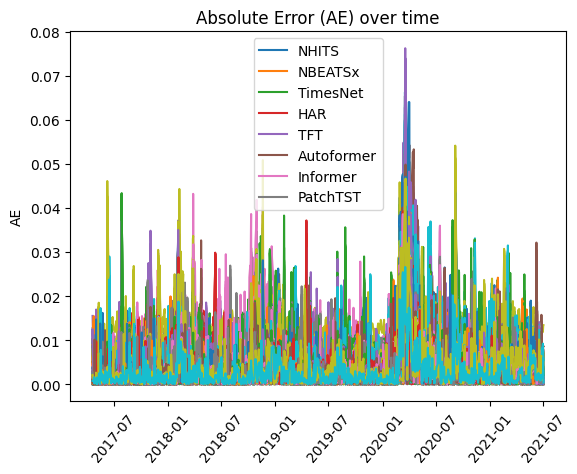

NHITS MAE: 0.0032728018364762985
NBEATSx MAE: 0.0032923400977495393
TimesNet MAE: 0.003406839032788088
HAR MAE: 0.004136769003891564
TFT MAE: 0.0036341462709938844
Autoformer MAE: 0.0033545442167931066
Informer MAE: 0.003286245490825086
PatchTST MAE: 0.003378417608373368


In [20]:
  NHITS_MAE=abs(NHITS-Actuals)
  NBEATSx_MAE=abs(NBEATSx-Actuals)
  TFT_MAE=abs(TFT-Actuals)
  TimesNet_MAE=abs(TimesNet-Actuals)
  HAR_MAE=abs(HAR-Actuals)
  Autoformer_MAE=abs(Autoformer-Actuals)
  Informer_MAE=abs(Informer-Actuals)
  PatchTST_MAE=abs(PatchTST-Actuals)

  plt.plot(NHITS_MAE)
  plt.plot(NBEATSx_MAE)
  plt.plot(TimesNet_MAE)
  plt.plot(HAR_MAE)
  plt.plot(TFT_MAE)
  plt.plot(Autoformer_MAE)
  plt.plot(Informer_MAE)
  plt.plot(PatchTST_MAE)
  plt.ylabel("AE")
  plt.title("Absolute Error (AE) over time")
  plt.legend(['NHITS','NBEATSx', 'TimesNet', 'HAR', 'TFT', 'Autoformer', 'Informer', 'PatchTST'])
  plt.xticks(rotation=50)
  plt.show()

  NHITS_MAE=(NHITS_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  NBEATSx_MAE=(NBEATSx_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  TFT_MAE=(TFT_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  TimesNet_MAE=(TimesNet_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  HAR_MAE=(HAR_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  Autoformer_MAE=(Autoformer_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  Informer_MAE=(Informer_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  PatchTST_MAE=(PatchTST_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

  print(f"NHITS MAE: {NHITS_MAE}")
  print(f"NBEATSx MAE: {NBEATSx_MAE}")
  print(f"TimesNet MAE: {TimesNet_MAE}")
  print(f"HAR MAE: {HAR_MAE}")
  print(f"TFT MAE: {TFT_MAE}")
  print(f"Autoformer MAE: {Autoformer_MAE}")
  print(f"Informer MAE: {Informer_MAE}")
  print(f"PatchTST MAE: {PatchTST_MAE}")

QLIKE

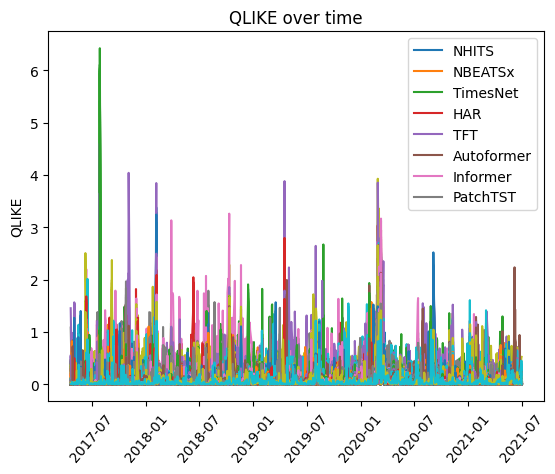

NHITS QLIKE: 0.06016980205405628
NBEATSx QLIKE: 0.05935792366380553
TimesNet QLIKE: 0.056340484967591364
HAR QLIKE: 0.08829269484914663
TFT QLIKE: 0.057641180300680744
Autoformer QLIKE: 0.06022691596409752
Informer QLIKE: 0.0599198296993395
PatchTST QLIKE: 0.055977348823993946


In [21]:
  NHITS_QLIKE=(Actuals/NHITS)-np.log(Actuals/NHITS)-1
  NBEATSx_QLIKE=(Actuals/NBEATSx)-np.log(Actuals/NBEATSx)-1
  TFT_QLIKE=(Actuals/TFT)-np.log(Actuals/TFT)-1
  TimesNet_QLIKE=(Actuals/TimesNet)-np.log(Actuals/TimesNet)-1
  HAR_QLIKE=(Actuals/HAR)-np.log(Actuals/HAR)-1
  Autoformer_QLIKE=(Actuals/Autoformer)-np.log(Actuals/Autoformer)-1
  Informer_QLIKE=(Actuals/Informer)-np.log(Actuals/Informer)-1
  PatchTST_QLIKE=(Actuals/PatchTST)-np.log(Actuals/PatchTST)-1

  plt.plot(NHITS_QLIKE)
  plt.plot(NBEATSx_QLIKE)
  plt.plot(TimesNet_QLIKE)
  plt.plot(HAR_QLIKE)
  plt.plot(TFT_QLIKE)
  plt.plot(Autoformer_QLIKE)
  plt.plot(Informer_QLIKE)
  plt.plot(PatchTST_QLIKE)
  plt.ylabel("QLIKE")
  plt.title("QLIKE over time")
  plt.legend(['NHITS','NBEATSx', 'TimesNet', 'HAR', 'TFT', 'Autoformer', 'Informer', 'PatchTST'])
  plt.xticks(rotation=50)
  plt.show()

  NHITS_QLIKE=(NHITS_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  NBEATSx_QLIKE=(NBEATSx_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  TFT_QLIKE=(TFT_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  TimesNet_QLIKE=(TimesNet_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  HAR_QLIKE=(HAR_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  Autoformer_QLIKE=(Autoformer_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  Informer_QLIKE=(Informer_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  PatchTST_QLIKE=(PatchTST_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

  print(f"NHITS QLIKE: {NHITS_QLIKE}")
  print(f"NBEATSx QLIKE: {NBEATSx_QLIKE}")
  print(f"TimesNet QLIKE: {TimesNet_QLIKE}")
  print(f"HAR QLIKE: {HAR_QLIKE}")
  print(f"TFT QLIKE: {TFT_QLIKE}")
  print(f"Autoformer QLIKE: {Autoformer_QLIKE}")
  print(f"Informer QLIKE: {Informer_QLIKE}")
  print(f"PatchTST QLIKE: {PatchTST_QLIKE}")

MAPE

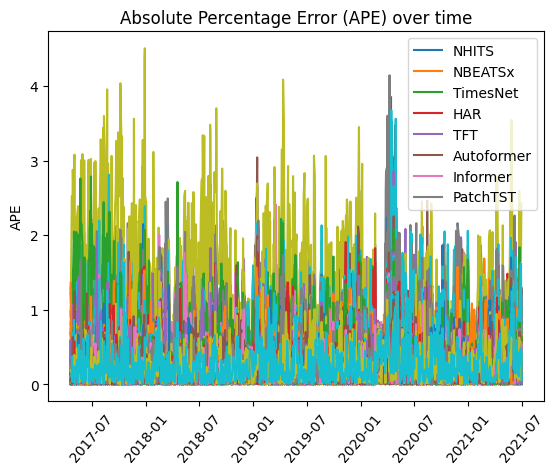

NHITS MAPE: 0.2349882279066087
NBEATSx MAPE: 0.23713191250657584
TimesNet MAPE: 0.25682292567247234
HAR MAPE: 0.342481962872503
TFT MAPE: 0.28019833023193824
Autoformer MAPE: 0.24460803409301873
Informer MAPE: 0.23320554803985627
PatchTST MAPE: 0.25724054560841536


In [22]:
  NHITS_MAPE=abs(NHITS-Actuals)/Actuals
  NBEATSx_MAPE=abs(NBEATSx-Actuals)/Actuals
  TFT_MAPE=abs(TFT-Actuals)/Actuals
  TimesNet_MAPE=abs(TimesNet-Actuals)/Actuals
  HAR_MAPE=abs(HAR-Actuals)/Actuals
  Autoformer_MAPE=abs(Autoformer-Actuals)/Actuals
  Informer_MAPE=abs(Informer-Actuals)/Actuals
  PatchTST_MAPE=abs(PatchTST-Actuals)/Actuals

  plt.plot(NHITS_MAPE)
  plt.plot(NBEATSx_MAPE)
  plt.plot(TimesNet_MAPE)
  plt.plot(HAR_MAPE)
  plt.plot(TFT_MAPE)
  plt.plot(Autoformer_MAPE)
  plt.plot(Informer_MAPE)
  plt.plot(PatchTST_MAPE)
  plt.ylabel("APE")
  plt.title("Absolute Percentage Error (APE) over time")
  plt.legend(['NHITS','NBEATSx', 'TimesNet', 'HAR', 'TFT', 'Autoformer', 'Informer', 'PatchTST'])
  plt.xticks(rotation=50)
  plt.show()

  NHITS_MAPE=(NHITS_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  NBEATSx_MAPE=(NBEATSx_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  TFT_MAPE=(TFT_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  TimesNet_MAPE=(TimesNet_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  HAR_MAPE=(HAR_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  Autoformer_MAPE=(Autoformer_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  Informer_MAPE=(Informer_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
  PatchTST_MAPE=(PatchTST_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

  print(f"NHITS MAPE: {NHITS_MAPE}")
  print(f"NBEATSx MAPE: {NBEATSx_MAPE}")
  print(f"TimesNet MAPE: {TimesNet_MAPE}")
  print(f"HAR MAPE: {HAR_MAPE}")
  print(f"TFT MAPE: {TFT_MAPE}")
  print(f"Autoformer MAPE: {Autoformer_MAPE}")
  print(f"Informer MAPE: {Informer_MAPE}")
  print(f"PatchTST MAPE: {PatchTST_MAPE}")

In [23]:
# Creating a dataframe with the error metrics as columns and models as the index
error_metrics_data = {
    'RMSE': [NHITS_RMSE, HAR_RMSE, TimesNet_RMSE, NBEATSx_RMSE, TFT_RMSE, Autoformer_RMSE, Informer_RMSE, PatchTST_RMSE],
    'MAE': [NHITS_MAE, HAR_MAE, TimesNet_MAE,NBEATSx_MAE, TFT_MAE, Autoformer_MAE, Informer_MAE, PatchTST_MAE],
    'MAPE': [NHITS_MAPE, HAR_MAPE, TimesNet_MAPE, NBEATSx_MAPE, TFT_MAPE, Autoformer_MAPE, Informer_MAPE, PatchTST_MAPE],
    'QLIKE': [NHITS_QLIKE, HAR_QLIKE, TimesNet_QLIKE, NBEATSx_QLIKE, TFT_QLIKE, Autoformer_QLIKE, Informer_QLIKE, PatchTST_QLIKE]
}

models = ['NHITS', 'HAR', 'TimesNet', 'NBEATSx', 'TFT', 'Autoformer', 'Informer', 'PatchTST']

# Create the DataFrame
error_metrics_df = pd.DataFrame(data=error_metrics_data, index=models)

error_metrics_df

,RMSE,MAE,MAPE,QLIKE
NHITS,0.005633,0.003273,0.234988,0.060170
HAR,0.006379,0.004137,0.342482,0.088293
TimesNet,0.005612,0.003407,0.256823,0.056340
NBEATSx,0.005645,0.003292,0.237132,0.059358
TFT,0.005918,0.003634,0.280198,0.057641
Autoformer,0.005710,0.003355,0.244608,0.060227
Informer,0.005680,0.003286,0.233206,0.059920
PatchTST,0.005480,0.003378,0.257241,0.055977


# MCS RMSE

In [24]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 7.2 MB/s eta 0:00:00


In [25]:
from arch.bootstrap import MCS

NHITS_residuals=(NHITS-Actuals)**2
NBEATSx_residuals=(NBEATSx-Actuals)**2
TFT_residuals=(TFT-Actuals)**2
TimesNet_residuals=(TimesNet-Actuals)**2
HAR_residuals=(HAR-Actuals)**2
Autoformer_residuals=(Autoformer-Actuals)**2
Informer_residuals=(Informer-Actuals)**2
PatchTST_residuals=(PatchTST-Actuals)**2

NHITS_residuals=(NHITS_residuals.sum(axis=1)/(len(Actuals.columns)))
NBEATSx_residuals=(NBEATSx_residuals.sum(axis=1)/(len(Actuals.columns)))
TFT_residuals=(TFT_residuals.sum(axis=1)/(len(Actuals.columns)))
TimesNet_residuals=(TimesNet_residuals.sum(axis=1)/(len(Actuals.columns)))
HAR_residuals=(HAR_residuals.sum(axis=1)/(len(Actuals.columns)))
Autoformer_residuals=(Autoformer_residuals.sum(axis=1)/(len(Actuals.columns)))
Informer_residuals=(Informer_residuals.sum(axis=1)/(len(Actuals.columns)))
PatchTST_residuals=(PatchTST_residuals.sum(axis=1)/(len(Actuals.columns)))


losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TimesNet': TimesNet_residuals,
              'HAR': HAR_residuals,
              'TFT': TFT_residuals,
                       'Autoformer': Autoformer_residuals,
                       'Informer': Informer_residuals,
                       'PatchTST': PatchTST_residuals})

mcs = MCS(losses, size=0.05, method="R", block_size=1000)
mcs.compute()
print("MCS P-values")
print(mcs.pvalues)
print("Included")
included = mcs.included
print(included)
print("Excluded")
excluded = mcs.excluded
print(excluded)

MCS P-values
            Pvalue
Model name        
HAR          0.000
Autoformer   0.068
TFT          0.069
Informer     0.275
TimesNet     0.293
NBEATSx      0.293
NHITS        0.293
PatchTST     1.000
Included
['Autoformer', 'Informer', 'NBEATSx', 'NHITS', 'PatchTST', 'TFT', 'TimesNet']
Excluded
['HAR']


# MCS MAE

In [26]:
NHITS_residuals=abs(NHITS-Actuals)
NBEATSx_residuals=abs(NBEATSx-Actuals)
TFT_residuals=abs(TFT-Actuals)
TimesNet_residuals=abs(TimesNet-Actuals)
HAR_residuals=abs(HAR-Actuals)
Autoformer_residuals=abs(Autoformer-Actuals)
Informer_residuals=abs(Informer-Actuals)
PatchTST_residuals=abs(PatchTST-Actuals)

NHITS_residuals=(NHITS_residuals.sum(axis=1)/(len(Actuals.columns)))
NBEATSx_residuals=(NBEATSx_residuals.sum(axis=1)/(len(Actuals.columns)))
TFT_residuals=(TFT_residuals.sum(axis=1)/(len(Actuals.columns)))
TimesNet_residuals=(TimesNet_residuals.sum(axis=1)/(len(Actuals.columns)))
HAR_residuals=(HAR_residuals.sum(axis=1)/(len(Actuals.columns)))
Autoformer_residuals=(Autoformer_residuals.sum(axis=1)/(len(Actuals.columns)))
Informer_residuals=(Informer_residuals.sum(axis=1)/(len(Actuals.columns)))
PatchTST_residuals=(PatchTST_residuals.sum(axis=1)/(len(Actuals.columns)))


losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TimesNet': TimesNet_residuals,
              'HAR': HAR_residuals,
              'TFT': TFT_residuals,
                       'Autoformer': Autoformer_residuals,
                       'Informer': Informer_residuals,
                       'PatchTST': PatchTST_residuals})

mcs = MCS(losses, size=0.05, method="R", block_size=1000)
mcs.compute()
print("MCS P-values")
print(mcs.pvalues)
print("Included")
included = mcs.included
print(included)
print("Excluded")
excluded = mcs.excluded
print(excluded)

MCS P-values
            Pvalue
Model name        
HAR          0.000
TimesNet     0.000
TFT          0.000
PatchTST     0.047
NBEATSx      0.108
Autoformer   0.142
Informer     0.177
NHITS        1.000
Included
['Autoformer', 'Informer', 'NBEATSx', 'NHITS']
Excluded
['HAR', 'PatchTST', 'TFT', 'TimesNet']


# MCS QLIKE

In [27]:
NHITS_residuals=(Actuals/NHITS)-np.log(Actuals/NHITS)-1
NBEATSx_residuals=(Actuals/NBEATSx)-np.log(Actuals/NBEATSx)-1
TFT_residuals=(Actuals/TFT)-np.log(Actuals/TFT)-1
TimesNet_residuals=(Actuals/TimesNet)-np.log(Actuals/TimesNet)-1
HAR_residuals=(Actuals/HAR)-np.log(Actuals/HAR)-1
Autoformer_residuals=(Actuals/Autoformer)-np.log(Actuals/Autoformer)-1
Informer_residuals=(Actuals/Informer)-np.log(Actuals/Informer)-1
PatchTST_residuals=(Actuals/PatchTST)-np.log(Actuals/PatchTST)-1

NHITS_residuals=(NHITS_residuals.sum(axis=1)/(len(Actuals.columns)))
NBEATSx_residuals=(NBEATSx_residuals.sum(axis=1)/(len(Actuals.columns)))
TFT_residuals=(TFT_residuals.sum(axis=1)/(len(Actuals.columns)))
TimesNet_residuals=(TimesNet_residuals.sum(axis=1)/(len(Actuals.columns)))
HAR_residuals=(HAR_residuals.sum(axis=1)/(len(Actuals.columns)))
Autoformer_residuals=(Autoformer_residuals.sum(axis=1)/(len(Actuals.columns)))
Informer_residuals=(Informer_residuals.sum(axis=1)/(len(Actuals.columns)))
PatchTST_residuals=(PatchTST_residuals.sum(axis=1)/(len(Actuals.columns)))


losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TimesNet': TimesNet_residuals,
              'HAR': HAR_residuals,
              'TFT': TFT_residuals,
                       'Autoformer': Autoformer_residuals,
                       'Informer': Informer_residuals,
                       'PatchTST': PatchTST_residuals})

mcs = MCS(losses, size=0.05, method="R", block_size=1000)
mcs.compute()
print("MCS P-values")
print(mcs.pvalues)
print("Included")
included = mcs.included
print(included)
print("Excluded")
excluded = mcs.excluded
print(excluded)

MCS P-values
            Pvalue
Model name        
HAR          0.000
Autoformer   0.000
NHITS        0.007
Informer     0.007
TFT          0.018
NBEATSx      0.018
TimesNet     0.348
PatchTST     1.000
Included
['PatchTST', 'TimesNet']
Excluded
['Autoformer', 'HAR', 'Informer', 'NBEATSx', 'NHITS', 'TFT']


# MCS MAPE

In [28]:
NHITS_residuals=abs(NHITS-Actuals)/Actuals
NBEATSx_residuals=abs(NBEATSx-Actuals)/Actuals
TFT_residuals=abs(TFT-Actuals)/Actuals
TimesNet_residuals=abs(TimesNet-Actuals)/Actuals
HAR_residuals=abs(HAR-Actuals)/Actuals
Autoformer_residuals=abs(Autoformer-Actuals)/Actuals
Informer_residuals=abs(Informer-Actuals)/Actuals
PatchTST_residuals=abs(PatchTST-Actuals)/Actuals


NHITS_residuals=(NHITS_residuals.sum(axis=1)/(len(Actuals.columns)))
NBEATSx_residuals=(NBEATSx_residuals.sum(axis=1)/(len(Actuals.columns)))
TFT_residuals=(TFT_residuals.sum(axis=1)/(len(Actuals.columns)))
TimesNet_residuals=(TimesNet_residuals.sum(axis=1)/(len(Actuals.columns)))
HAR_residuals=(HAR_residuals.sum(axis=1)/(len(Actuals.columns)))
Autoformer_residuals=(Autoformer_residuals.sum(axis=1)/(len(Actuals.columns)))
Informer_residuals=(Informer_residuals.sum(axis=1)/(len(Actuals.columns)))
PatchTST_residuals=(PatchTST_residuals.sum(axis=1)/(len(Actuals.columns)))


losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TimesNet': TimesNet_residuals,
              'HAR': HAR_residuals,
              'TFT': TFT_residuals,
                       'Autoformer': Autoformer_residuals,
                       'Informer': Informer_residuals,
                       'PatchTST': PatchTST_residuals})

mcs = MCS(losses, size=0.05, method="R", block_size=1000)
mcs.compute()
print("MCS P-values")
print(mcs.pvalues)
print("Included")
included = mcs.included
print(included)
print("Excluded")
excluded = mcs.excluded
print(excluded)

MCS P-values
            Pvalue
Model name        
TFT          0.000
TimesNet     0.000
HAR          0.000
PatchTST     0.000
NBEATSx      0.000
Autoformer   0.007
NHITS        0.111
Informer     1.000
Included
['Informer', 'NHITS']
Excluded
['Autoformer', 'HAR', 'NBEATSx', 'PatchTST', 'TFT', 'TimesNet']


# Dynamic MCS with MSE

Alphabetic Order: Autoformer, HAR, Informer, NBEATSx, NHITS, PatchTST, TFT, TimesNet

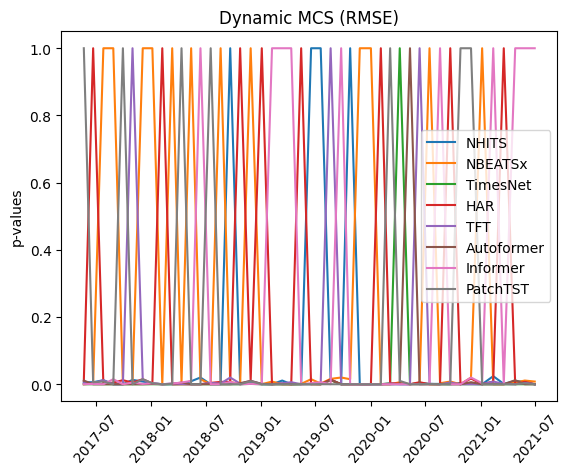

In [29]:
NHITS_residuals=(NHITS-Actuals)**2
NBEATSx_residuals=(NBEATSx-Actuals)**2
TFT_residuals=(TFT-Actuals)**2
TimesNet_residuals=(TimesNet-Actuals)**2
HAR_residuals=(HAR-Actuals)**2
Autoformer_residuals=(Autoformer-Actuals)**2
Informer_residuals=(Informer-Actuals)**2
PatchTST_residuals=(PatchTST-Actuals)**2

NHITS_residuals=(NHITS_residuals.sum(axis=1)/(len(Actuals.columns)))
NBEATSx_residuals=(NBEATSx_residuals.sum(axis=1)/(len(Actuals.columns)))
TFT_residuals=(TFT_residuals.sum(axis=1)/(len(Actuals.columns)))
TimesNet_residuals=(TimesNet_residuals.sum(axis=1)/(len(Actuals.columns)))
HAR_residuals=(HAR_residuals.sum(axis=1)/(len(Actuals.columns)))
Autoformer_residuals=(Autoformer_residuals.sum(axis=1)/(len(Actuals.columns)))
Informer_residuals=(Informer_residuals.sum(axis=1)/(len(Actuals.columns)))
PatchTST_residuals=(PatchTST_residuals.sum(axis=1)/(len(Actuals.columns)))


losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TimesNet': TimesNet_residuals,
              'HAR': HAR_residuals,
              'TFT': TFT_residuals,
                       'Autoformer': Autoformer_residuals,
                       'Informer': Informer_residuals,
                       'PatchTST': PatchTST_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),8])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=1000)
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(8)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'Autoformer':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'Informer':Dynamic_pvalues[:,2],
       'NBEATSx':Dynamic_pvalues[:,3],
       'NHITS':Dynamic_pvalues[:,4],
       'PatchTST':Dynamic_pvalues[:,5],
       'TFT':Dynamic_pvalues[:,6],
        'TimesNet':Dynamic_pvalues[:,7],

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["TimesNet"])
plt.plot(Pvalues.index,Pvalues["Autoformer"])
plt.plot(Pvalues.index,Pvalues["Informer"])
plt.plot(Pvalues.index,Pvalues["PatchTST"])
plt.legend(['NHITS','NBEATSx', 'TimesNet', 'HAR', 'TFT', 'Autoformer', 'Informer', 'PatchTST'])
plt.ylabel("p-values")
plt.title("Dynamic MCS (RMSE)")
plt.xticks(rotation=50)
plt.show()

# Dynamic MCS test with MAE

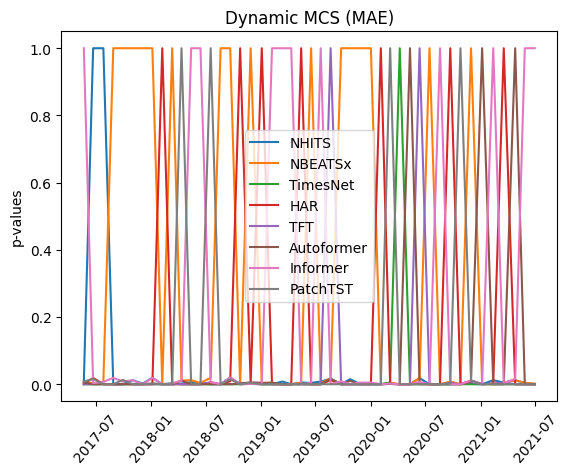

In [30]:
NHITS_residuals=abs(NHITS-Actuals)
NBEATSx_residuals=abs(NBEATSx-Actuals)
TFT_residuals=abs(TFT-Actuals)
TimesNet_residuals=abs(TimesNet-Actuals)
HAR_residuals=abs(HAR-Actuals)
Autoformer_residuals=abs(Autoformer-Actuals)
Informer_residuals=abs(Informer-Actuals)
PatchTST_residuals=abs(PatchTST-Actuals)

NHITS_residuals=(NHITS_residuals.sum(axis=1)/(len(Actuals.columns)))
NBEATSx_residuals=(NBEATSx_residuals.sum(axis=1)/(len(Actuals.columns)))
TFT_residuals=(TFT_residuals.sum(axis=1)/(len(Actuals.columns)))
TimesNet_residuals=(TimesNet_residuals.sum(axis=1)/(len(Actuals.columns)))
HAR_residuals=(HAR_residuals.sum(axis=1)/(len(Actuals.columns)))
Autoformer_residuals=(Autoformer_residuals.sum(axis=1)/(len(Actuals.columns)))
Informer_residuals=(Informer_residuals.sum(axis=1)/(len(Actuals.columns)))
PatchTST_residuals=(PatchTST_residuals.sum(axis=1)/(len(Actuals.columns)))


losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TimesNet': TimesNet_residuals,
              'HAR': HAR_residuals,
              'TFT': TFT_residuals,
                       'Autoformer': Autoformer_residuals,
                       'Informer': Informer_residuals,
                       'PatchTST': PatchTST_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),8])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=1000)
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(8)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'Autoformer':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'Informer':Dynamic_pvalues[:,2],
       'NBEATSx':Dynamic_pvalues[:,3],
       'NHITS':Dynamic_pvalues[:,4],
       'PatchTST':Dynamic_pvalues[:,5],
       'TFT':Dynamic_pvalues[:,6],
        'TimesNet':Dynamic_pvalues[:,7],

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["TimesNet"])
plt.plot(Pvalues.index,Pvalues["Autoformer"])
plt.plot(Pvalues.index,Pvalues["Informer"])
plt.plot(Pvalues.index,Pvalues["PatchTST"])
plt.legend(['NHITS','NBEATSx', 'TimesNet', 'HAR', 'TFT', 'Autoformer', 'Informer', 'PatchTST'])
plt.ylabel("p-values")
plt.title("Dynamic MCS (MAE)")
plt.xticks(rotation=50)
plt.show()

# Dynamic MCS test with QLIKE

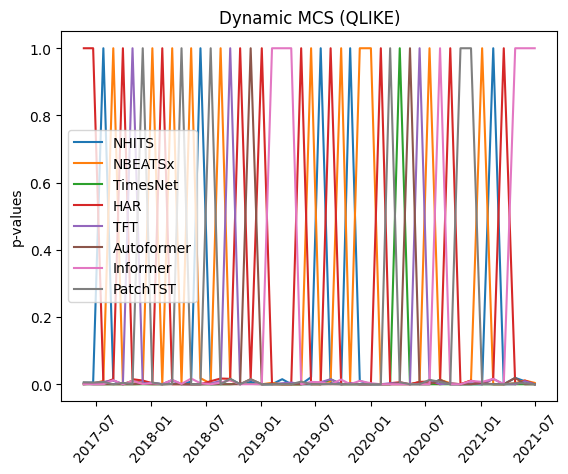

In [31]:
NHITS_residuals=(Actuals/NHITS)-np.log(Actuals/NHITS)-1
NBEATSx_residuals=(Actuals/NBEATSx)-np.log(Actuals/NBEATSx)-1
TFT_residuals=(Actuals/TFT)-np.log(Actuals/TFT)-1
TimesNet_residuals=(Actuals/TimesNet)-np.log(Actuals/TimesNet)-1
HAR_residuals=(Actuals/HAR)-np.log(Actuals/HAR)-1
Autoformer_residuals=(Actuals/Autoformer)-np.log(Actuals/Autoformer)-1
Informer_residuals=(Actuals/Informer)-np.log(Actuals/Informer)-1
PatchTST_residuals=(Actuals/PatchTST)-np.log(Actuals/PatchTST)-1

NHITS_residuals=(NHITS_residuals.sum(axis=1)/(len(Actuals.columns)))
NBEATSx_residuals=(NBEATSx_residuals.sum(axis=1)/(len(Actuals.columns)))
TFT_residuals=(TFT_residuals.sum(axis=1)/(len(Actuals.columns)))
TimesNet_residuals=(TimesNet_residuals.sum(axis=1)/(len(Actuals.columns)))
HAR_residuals=(HAR_residuals.sum(axis=1)/(len(Actuals.columns)))
Autoformer_residuals=(Autoformer_residuals.sum(axis=1)/(len(Actuals.columns)))
Informer_residuals=(Informer_residuals.sum(axis=1)/(len(Actuals.columns)))
PatchTST_residuals=(PatchTST_residuals.sum(axis=1)/(len(Actuals.columns)))


losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TimesNet': TimesNet_residuals,
              'HAR': HAR_residuals,
              'TFT': TFT_residuals,
                       'Autoformer': Autoformer_residuals,
                       'Informer': Informer_residuals,
                       'PatchTST': PatchTST_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),8])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=1000)
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(8)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'Autoformer':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'Informer':Dynamic_pvalues[:,2],
       'NBEATSx':Dynamic_pvalues[:,3],
       'NHITS':Dynamic_pvalues[:,4],
       'PatchTST':Dynamic_pvalues[:,5],
       'TFT':Dynamic_pvalues[:,6],
        'TimesNet':Dynamic_pvalues[:,7],

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["TimesNet"])
plt.plot(Pvalues.index,Pvalues["Autoformer"])
plt.plot(Pvalues.index,Pvalues["Informer"])
plt.plot(Pvalues.index,Pvalues["PatchTST"])
plt.legend(['NHITS','NBEATSx', 'TimesNet', 'HAR', 'TFT', 'Autoformer', 'Informer', 'PatchTST'])
plt.ylabel("p-values")
plt.title("Dynamic MCS (QLIKE)")
plt.xticks(rotation=50)
plt.show()

# MCS test with MAPE

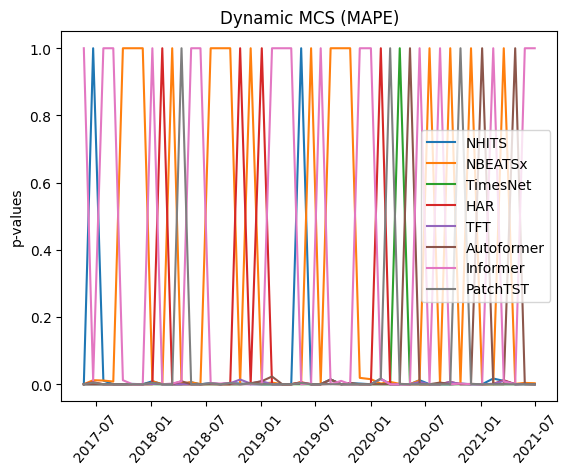

In [32]:
NHITS_residuals=abs(NHITS-Actuals)/Actuals
NBEATSx_residuals=abs(NBEATSx-Actuals)/Actuals
TFT_residuals=abs(TFT-Actuals)/Actuals
TimesNet_residuals=abs(TimesNet-Actuals)/Actuals
HAR_residuals=abs(HAR-Actuals)/Actuals
Autoformer_residuals=abs(Autoformer-Actuals)/Actuals
Informer_residuals=abs(Informer-Actuals)/Actuals
PatchTST_residuals=abs(PatchTST-Actuals)/Actuals

NHITS_residuals=(NHITS_residuals.sum(axis=1)/(len(Actuals.columns)))
NBEATSx_residuals=(NBEATSx_residuals.sum(axis=1)/(len(Actuals.columns)))
TFT_residuals=(TFT_residuals.sum(axis=1)/(len(Actuals.columns)))
TimesNet_residuals=(TimesNet_residuals.sum(axis=1)/(len(Actuals.columns)))
HAR_residuals=(HAR_residuals.sum(axis=1)/(len(Actuals.columns)))
Autoformer_residuals=(Autoformer_residuals.sum(axis=1)/(len(Actuals.columns)))
Informer_residuals=(Informer_residuals.sum(axis=1)/(len(Actuals.columns)))
PatchTST_residuals=(PatchTST_residuals.sum(axis=1)/(len(Actuals.columns)))


losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TimesNet': TimesNet_residuals,
              'HAR': HAR_residuals,
              'TFT': TFT_residuals,
                       'Autoformer': Autoformer_residuals,
                       'Informer': Informer_residuals,
                       'PatchTST': PatchTST_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),8])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=1000)
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(8)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'Autoformer':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'Informer':Dynamic_pvalues[:,2],
       'NBEATSx':Dynamic_pvalues[:,3],
       'NHITS':Dynamic_pvalues[:,4],
       'PatchTST':Dynamic_pvalues[:,5],
       'TFT':Dynamic_pvalues[:,6],
        'TimesNet':Dynamic_pvalues[:,7],

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["TimesNet"])
plt.plot(Pvalues.index,Pvalues["Autoformer"])
plt.plot(Pvalues.index,Pvalues["Informer"])
plt.plot(Pvalues.index,Pvalues["PatchTST"])
plt.legend(['NHITS','NBEATSx', 'TimesNet', 'HAR', 'TFT', 'Autoformer', 'Informer', 'PatchTST'])
plt.ylabel("p-values")
plt.title("Dynamic MCS (MAPE)")
plt.xticks(rotation=50)
plt.show()